<a href="https://colab.research.google.com/github/anismehmahi/pytorch/blob/main/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [ ]:
class MyModel(nn.Module):
  def __init__(self, input_image_size, num_classes):
    super(MyModel,self).__init__()
    self.layer1 = nn.Linear(60, 10)
    # the input tensor should be of shape (N, T, D) and when defining RNN this is it should be = RNN(input_size = D, hidden_size = Hout, num_layers = 1 or 2, batch_first=True, nonlinearity='relu' or 'tanh')
    self.rnn = nn.RNN(28, 60, 1, batch_first=True, nonlinearity='tanh')
    # self.layer2 = nn.Linear(50,num_classes)
  def forward(self,x):
    # x is of shape (N, T, D) = (batch_size, T, Hin)
    x, hn = self.rnn(x) # hn is of shape = (1, batch_size, 60)
    # print(hn.shape)
    hn = torch.squeeze(hn) # to get rid of that 1 dim so the shape becomes (batch_size, 60)
    # print(hn.shape)
    hn= F.relu(self.layer1(hn))
    # print(hn.shape)
    return hn



    # x = F.relu(self.layer1(x))
    # x = self.layer2(x)
    # return x


In [ ]:
image_input_size = 784
num_classes = 10
model = MyModel(image_input_size, num_classes)
rand = torch.rand(32,28,28)
last_layer_embeddings = model(rand)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
learning_rate = 0.001
batch_size = 32

In [ ]:
train_dataset = datasets.MNIST(root='/content/data/', train=True, transform = transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='/content/data/', train=False, transform = transforms.ToTensor(), download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 140075170.12it/s]

Extracting /content/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 24020561.93it/s]

Extracting /content/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 38878877.67it/s]

Extracting /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 16451233.82it/s]


Extracting /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/MNIST/raw



In [ ]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True,)
test_loader = DataLoader(test_dataset,batch_size = batch_size, shuffle=True)

In [ ]:
for batch, labels in test_loader:
  print(batch.shape)
  break

torch.Size([32, 1, 28, 28])


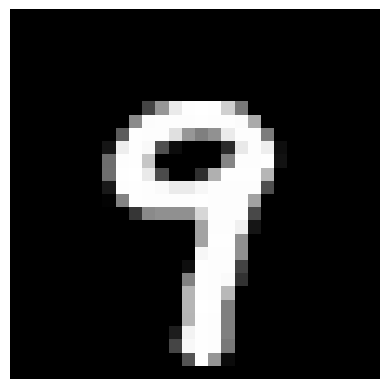

In [ ]:
import matplotlib.pyplot as plt

for batch, labels in test_loader:
  plt.imshow(batch[0].squeeze(), cmap='gray')
  plt.axis('off')  # Turn off axis
  plt.show()
  break

In [ ]:
# The true formula of CE in pytorch is (log is natural): loss(x, class) = -log(exp(x[class]) / (\sum_j exp(x[j])))
#                                                        = -x[class] + log(\sum_j exp(x[j]))
# We do this for each entry (row in our data) and then we sum or mean all what we get based on the reduction attribute in nn.CrossEntropyLoss(reduction='sum') by default it is 'mean'
# it applies first softmax to logits (predicted) and then calculate the CE (CE = Sum (-pi*log(softmax(logits)))) pi in pytorch is always = 1
# https://stackoverflow.com/questions/49390842/cross-entropy-in-pytorch
criterion = nn.CrossEntropyLoss(reduction='mean')

### Playing with loss function

In [ ]:
# The true formula of CE in pytorch is (log is natural): loss(x, class) = -log(exp(x[class]) / (\sum_j exp(x[j])))
#                                                        = -x[class] + log(\sum_j exp(x[j]))
# We do this for each entry (row in our data) and then we sum or mean all what we get based on the reduction attribute in nn.CrossEntropyLoss(reduction='sum') by default it is 'mean'
# it applies first softmax to logits (predicted) and then calculate the CE (CE = Sum (-pi*log(softmax(logits)))) pi in pytorch is always = 1
# https://stackoverflow.com/questions/49390842/cross-entropy-in-pytorch

predicted = torch.tensor([[1,0],[0,1]],dtype=torch.float)
true = torch.tensor([1,0]).long()

loss = criterion(predicted,true)
print(loss)

tensor(2.6265)


In [ ]:
import math

result =  math.log(1 + math.exp(1)) + math.log(1 + math.exp(1))
print(result)

2.6265233750364456


### Back to training loop

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
epochs = 10
model.train()
model.to(device)

for epoch in range(epochs):
    # Training
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        optimizer.zero_grad()
        batch = torch.squeeze(batch)
        # batch = batch.reshape(batch.shape[0], -1) # batch_sizex784
        # Forward pass
        outputs = model(batch) #output shape is 32x10
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()

    print('[%d] training loss: %.3f' %(epoch + 1, running_loss / len(train_loader)))

    # Evaluation
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for data in test_loader:
            batch, labels = data
            batch, labels = batch.to(device), labels.to(device)
            # batch = batch.reshape(batch.shape[0], -1) # batch_sizex784
            batch = torch.squeeze(batch)
            outputss = model(batch)
            _, predicted = torch.max(outputss, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples
    print('[%d] validation accuracy: %.3f' %(epoch + 1, accuracy))

    model.train()  # Set the model back to training mode

print('Finished Training')


[1] training loss: 0.833
[1] validation accuracy: 0.866
[2] training loss: 0.380
[2] validation accuracy: 0.915
[3] training loss: 0.296
[3] validation accuracy: 0.923
[4] training loss: 0.256
[4] validation accuracy: 0.931
[5] training loss: 0.230
[5] validation accuracy: 0.926
[6] training loss: 0.221
[6] validation accuracy: 0.947
[7] training loss: 0.204
[7] validation accuracy: 0.935
[8] training loss: 0.193
[8] validation accuracy: 0.949
[9] training loss: 0.192
[9] validation accuracy: 0.954
[10] training loss: 0.171
[10] validation accuracy: 0.947
Finished Training
